# Customer Segmentation Part III : Customer Clustering

## Topic
In the previous notebooks, we went through the 9 datasets provided by Olist; we did some processing before merging the dataframes together, did some exploratory data analysis to better understand the business and its trends. I of course deleted many irrelevant column like those containing dates and ids. So in this final notebook, we'll go through some clustering algorithms, use them to predict results and evaluate those results to choose the best model for our case.

## Objective
 Build and try different clustering models and choose one that can best segment the clients.

## Summary
- Importing libraries
- Loading the dataset
- Dealing with outliers
- Splitting the dataset
- Preparing the data for ML algorithms
- Kmeans (centroid based clustering):
  - Silhouette plot
  - Elbow plot
- DBSCAN (density based clustering):
  - Minpts 
  - Epsilon
- Gaussian mixture model
- Evaluation matrices:
  - Silhouette score
  - CH index
  - Davies Boulding index
- Comparing models' performences
- Conclusion
- references

## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc = {'figure.figsize':(15,8)})

# Processing the data
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Spliting data 
from sklearn.model_selection import train_test_split

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

from sklearn import metrics
from sklearn.metrics import davies_bouldin_score

## Importing the dataset

In [3]:
data = pd.read_csv(r'C:\Users\imane\OneDrive\Desktop\Clients_Clustering\treated_ML.csv', sep =",")
data.head()

,order_status,est_act_shipp,shipping_duration,shipping_est_duration,quantity,price,freight_value,product_photos_qty,product_weight_g,product_volume_ltr,...,payment_value,review_score,seller_city,seller_state,customer_city,customer_state,product_category_name,limit_delivery_diff,Total_cost,total_revenue
0,delivered,44,22,66,1,69.99,23.36,1.0,1200.0,5984.0,...,653.64,2,sao paulo,SP,vilhena,RO,furniture_decor,-18,93.35,69.99
1,delivered,44,22,66,1,69.99,23.36,1.0,1200.0,5984.0,...,653.64,2,sao paulo,SP,vilhena,RO,furniture_decor,-18,93.35,69.99
2,delivered,44,22,66,1,280.00,84.96,1.0,4000.0,43680.0,...,653.64,2,sao paulo,SP,vilhena,RO,furniture_decor,-3,364.96,280.00
3,delivered,-1,19,18,1,112.00,11.44,3.0,1400.0,14036.0,...,123.44,2,sao paulo,SP,sao paulo,SP,furniture_decor,-15,123.44,112.00
4,delivered,10,10,20,1,284.90,44.22,4.0,20300.0,113652.0,...,329.12,4,sao paulo,SP,taubate,SP,furniture_decor,-5,329.12,284.90


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98109 entries, 0 to 98108
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_status           98109 non-null  object 
 1   est_act_shipp          98109 non-null  int64  
 2   shipping_duration      98109 non-null  int64  
 3   shipping_est_duration  98109 non-null  int64  
 4   quantity               98109 non-null  int64  
 5   price                  98109 non-null  float64
 6   freight_value          98109 non-null  float64
 7   product_photos_qty     98109 non-null  float64
 8   product_weight_g       98109 non-null  float64
 9   product_volume_ltr     98109 non-null  float64
 10  payment_sequential     98109 non-null  int64  
 11  payment_type           98109 non-null  object 
 12  payment_installments   98109 non-null  int64  
 13  payment_value          98109 non-null  float64
 14  review_score           98109 non-null  int64  
 15  se

## Evaluating outliers

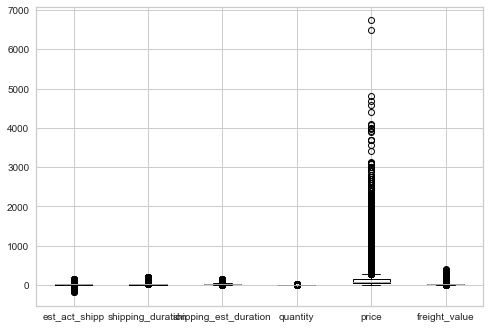

In [5]:
boxplots = data.boxplot(column=['est_act_shipp', 'shipping_duration', 'shipping_est_duration',
                               "quantity","price","freight_value"])

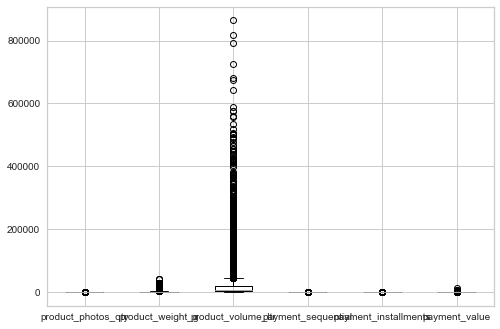

In [6]:
boxplots = data.boxplot(column=['product_photos_qty', 'product_weight_g', 'product_volume_ltr',
                               "payment_sequential","payment_installments","payment_value"])

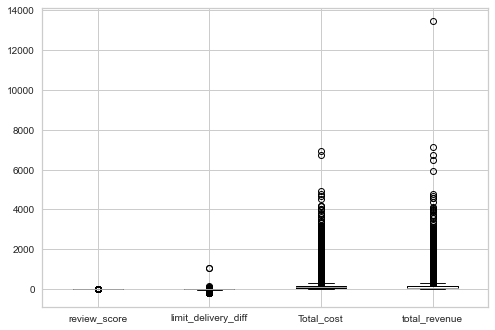

In [7]:
boxplots = data.boxplot(column=['review_score', 'limit_delivery_diff', 'Total_cost',
                               "total_revenue"])

Up to now, I've imported the dataset which contains numerical and categorical features, I ploted the box plots to take a look at outliers (because some of the clustering algorithms that I'm going to use are sensitive to outliers). We see that the features with the farthest outliers are total revenue, product volume and price. 

In [8]:
r = data["total_revenue"]
v = data["product_volume_ltr"]
p = data["price"]
n = data["product_category_name"]
d = pd.DataFrame()
d["total_revenue"] = r
d["product_volume_ltr"] = v
d["price"] = p
d["product_category_name"] = n
rev = d.sort_values(by="total_revenue", ascending=False)
rev.head()

,total_revenue,product_volume_ltr,price,product_category_name
15935,13440.0,32768.0,1680.0,fixed_telephony
15937,7160.0,25600.0,1790.0,fixed_telephony
3377,6735.0,120780.0,6735.0,housewares
96476,6499.0,29375.0,6499.0,art
97753,5934.6,50688.0,989.1,agro_industry_and_commerce


In [9]:
data.drop(data.index[(data["total_revenue"] > 7160)], axis = 0, inplace=True)

In [10]:
vol = d.sort_values(by="product_volume_ltr", ascending=False)
vol.head()

,total_revenue,product_volume_ltr,price,product_category_name
42498,1319.40,864000.0,219.90,computers_accessories
66587,1050.00,816480.0,175.00,signaling_and_security
67139,1559.92,793600.0,194.99,office_furniture
67429,1079.94,725760.0,179.99,office_furniture
53449,347.97,680943.0,115.99,cool_stuff


In [11]:
data.drop(data.index[(data["product_volume_ltr"] > 588000)], axis = 0, inplace=True)

In [12]:
pri = d.sort_values(by="price", ascending =False)
pri.head()

,total_revenue,product_volume_ltr,price,product_category_name
3377,6735.0,120780.0,6735.0,housewares
96476,6499.0,29375.0,6499.0,art
50911,4799.0,88000.0,4799.0,small_appliances
50912,4690.0,122500.0,4690.0,small_appliances
96898,4590.0,14000.0,4590.0,computers


In [13]:
data.drop(data.index[(data["price"] > 4000)], axis = 0, inplace=True)             

In the above part, I tried to dig a little deeper and see which products represent the outlying values. We see that the highest price was for a housewares product, the highest volume was for computer accessories products and the highest revenue of sale was for fixed telephony. All of these seem pretty logical and it's clear and they weren't recorded high by mistake.
So I decided to delete them because the dataset contains an handfull of instances.

In [14]:
data.select_dtypes("object").apply(pd.Series.nunique, axis = 0)

order_status                7
payment_type                4
seller_city                 2
seller_state                1
customer_city            4107
customer_state             27
product_category_name      71
dtype: int64

In [15]:
data = data.drop(["seller_state","seller_city","customer_city"], axis = 1)

Here I took a look at the number of categories each categorical feature has. Seller state has only one so I deleted it because it's no longer of any use. Seller city has 2 but they are both sao paulo (the accent is missing in some instances), so I deleted it too. Customer city on the other hand has a lot of categories. I also deleted customer city because it contains more than 4 thousand categories, and it'll take too long and charging to count all the zeros during one hot incoding.

## Splitting the train and test sets

In [16]:
train, test = train_test_split(data, test_size = 0.2,random_state = 42)

## Preparing data for ML 

In [17]:
# Seprating categircal features from numerical features
cat_train = train[["order_status","payment_type","customer_state","product_category_name"]].copy()
cat_test = test[["order_status","payment_type","customer_state","product_category_name"]].copy()

In [18]:
num_train = train.drop(["order_status","payment_type","customer_state","product_category_name"],axis=1)
num_test = test.drop(["order_status","payment_type","customer_state","product_category_name"],axis=1)

In [19]:
enc = OneHotEncoder()
sts = StandardScaler()
num_attr = list(num_train)
cat_attr = list(cat_train)
transform = ColumnTransformer([("num",sts,num_attr),("cat",enc,cat_attr)])
train_pre = transform.fit_transform(train)

In [20]:
num_attr = list(num_test)
cat_attr = list(cat_test)
transform = ColumnTransformer([("num",sts,num_attr),("cat",enc,cat_attr)])
test_pre = transform.fit_transform(test)

In [21]:
X = train_pre
Y = test_pre

After splitting the dataset into train and test (80% train), I seperated the categorical features from the numerical ones to be able to build a transformation pipeline using Column Transformer, I used the standard scaler for num categories and onehot encoding for categorical features.

## Kmeans (Centroid-based clustering)

### Silhouette Plot

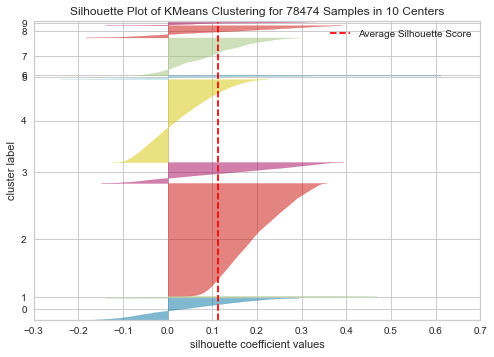

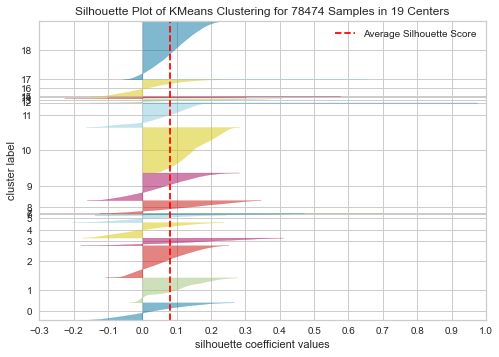

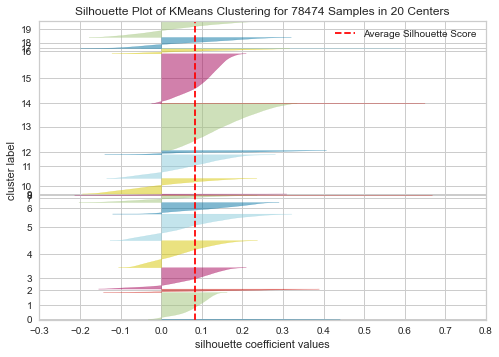

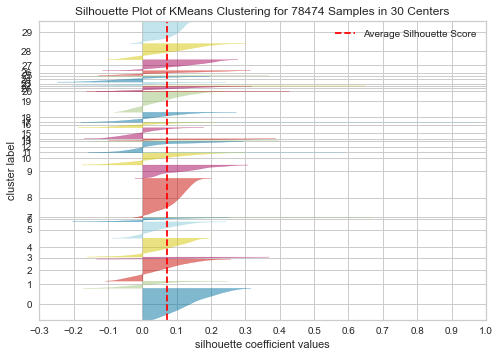

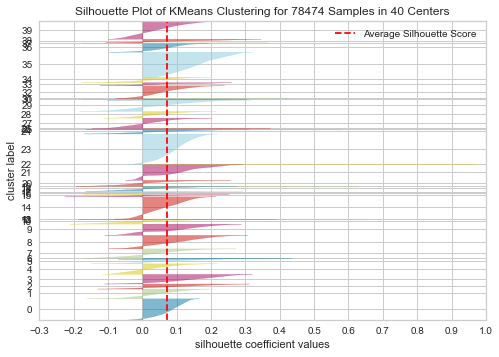

In [27]:
for i in [10,19, 20, 30, 40]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(X)
    visualizer.show()

The silhouette plots above helps us to choose the best number of clusters for this dataset. We notice that almost all the clusters have some components that were classified wrongly (the cluster leaning toward the negative), and that the clusters are somewhat similar in size (especially 40 clts), I'll use the elbow plot to gain more info. 

### Elbow plot

In [25]:
distortions = []
K = range(10, 41)
for k in K:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

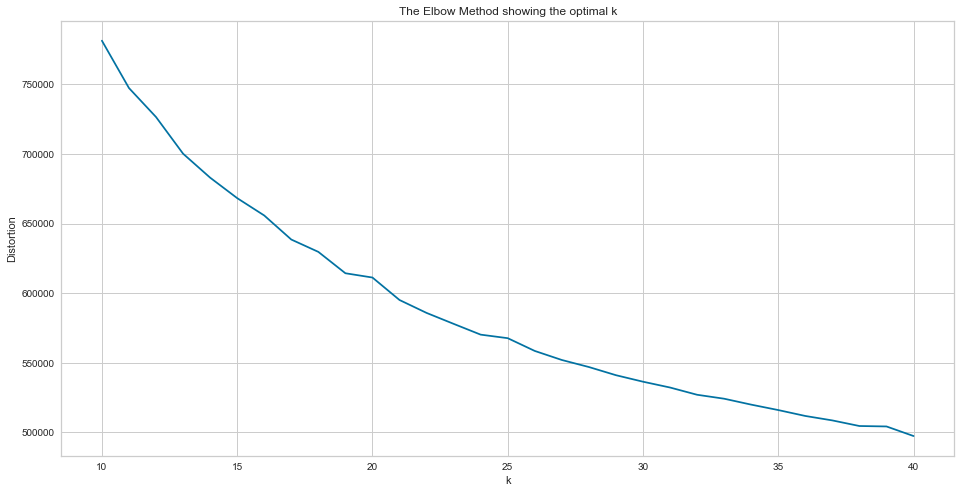

In [26]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow plot above shows us the WCSS (Within Cluster Sum of Square) for different cluster numbers. We notice that the elbow point (where the wcss starts to diminish) isn't very clear, but 19 seems to be the most adequate one.

From the above I've decided to go with 19 clusters for the Kmeans model, because it is the one that seems to have the most moderate cluster distribution and whose clusters shows an above average silhouette score.

#### Making predictions

In [28]:
kmeans = KMeans(init='k-means++',n_clusters=19,n_init=10,max_iter=300,random_state=42)

In [29]:
# Train the model
model = kmeans.fit(X)

In [30]:
# Assign each data point to a cluster
km_pred= kmeans.fit_predict(X)  

In [31]:
labels_km = model.labels_
labels_km

array([ 4, 18, 13, ..., 18,  2,  3])

In this part, I initiated Kmeans model with 19 clusters and used it to predict the test set.

## Evaluation matrices

### Silhouette plot/score

SilhouetteVisualizer(ax=<AxesSubplot:>, colors='yellowbrick',
                     estimator=KMeans(n_clusters=19, random_state=42))

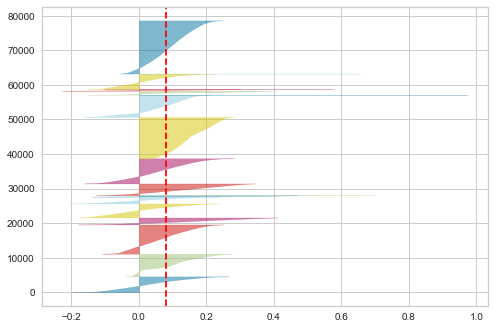

In [33]:
vis =  SilhouetteVisualizer(kmeans, colors='yellowbrick')
vis.fit(X)

In [35]:
s_score_km = silhouette_score(X, km_pred)
print("Silhouette score is: ", s_score_km)

Silhouette score is:  0.08082223720384082


The silhouette score and plot show that the classes are very close to each other and that some instances may have been clustered in the wrong category. Though all the clusters have a score above average.

### CH Index (Variance ratio criterion)

In [38]:
X_a = X.toarray()
ch_km = metrics.calinski_harabasz_score(X_a, labels_km)
print("CH index: ",ch_km)

CH index:  5749.418015222255


The CH index gives a result of above 5000 and we should compare it to the other algorithms' CH index. The CH index is used to measure the validity of the model , it is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters. The higher the result, the better.

### DB Index (Davies-Bouldin Index)

In [39]:
db_km = davies_bouldin_score(X_a, labels_km)
print("Davies Bouldin index: ",db_km)

Davies Bouldin index:  1.5343550902743526


The Davies Bouldin index is used to assess the similarity of the clusters. the lower its value is the better, because a DB index value close to 0 means that the clusters are dense and well separated. In our case we got 1.5 

## DBSCAN (Density-based clustering)

### Minimum Samples (“MinPts”)

When it comes to choosing the best number of min points for DBSCAN, there are a couple of pointers that proove to be helpful:
- The larger the data set, the larger the value of MinPts should be
- If the data set is noisier, choose a larger value of MinPts
- Generally, MinPts should be greater than or equal to the dimensionality of the data set
Since the dataset is large and contains 20 attributes and many outliers, I will go ahead with 40 as a minimun number of points.

### Epsilon (ε)

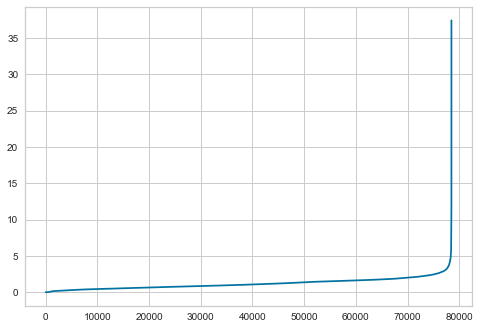

In [43]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=40)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In this part I used the Nearest neighbour algorithm to calculate the average distance between each instance and its neighbours.

The elbow plot above shows the average distance between each point in the dataset and its 40 nearest neighbors.The ideal value for ε will be equal to the distance value at the “crook of the elbow”, or the point of maximum curvature. This point represents the optimization point where diminishing returns are no longer worth the additional cost.
In our case the optimal epsilon value seems to be about 4 (the epsilon is the distance of measure for the DBSCAN model)

### Making predictions

In [ ]:
dbscan = DBSCAN(eps=4, min_samples=40)
# Train the model 
model = dbscan.fit(X)

In [ ]:
labels = model.labels_
labels

In [ ]:
# Assign each data point to a cluster
dbscan_pred = dbscan.fit_predict(X)

In [ ]:
# obtain all the unique clusters
dbscan_clstrs = np.unique(dbscan_pred)
dbscan_clstrs

In this part I have fit the model and made predictions using the test set, I used an epsilon distance of 7 and minimun points of 40. The results were less performant than Kmeans, because we see that DBSCAN made only two clusters, one of which is labelled 0 and the other -1 meaning that the model couldn't really cluster the instances within it.

### Evaluation matrices

### Silhouette score

In [176]:
s_score_sc = silhouette_score(X, dbscan_pred)
print("Silhouette score is: ", s_score_sc)

Silhouette score is:  0.8015248182116187


The silhouette score for DBSCAN is less than that of Kmeans, so far kmeans is favoured.

### CH index

In [178]:
X_a = X.toarray()
ch_sc = metrics.calinski_harabasz_score(X_a, labels)
print("CH index: ",ch_sc)

CH index:  817.2882397980351


The CH index score is also much lower than that achieved by Kmeans. A lower score means that the clusters are less dense and more dispersed.

### DB index

In [180]:
db_sc = davies_bouldin_score(X_a, labels)
print("Davies Bouldin index: ", db_sc)

Davies Bouldin index:  1.54976376072658


The DB index on the contrary give a lower (better) score than that of Kmeans. A lower DB score means that there are less similarities between the clusters.

## Gaussian mixture 

In [181]:
from sklearn import mixture
X_a = X.toarray()
gmm = mixture.GaussianMixture(n_components=19)
model = gmm.fit(X_a)

In [182]:
gmm_pred = gmm.fit_predict(X_a)

In [183]:
# Getting unique clusters names
gmm_clts = np.unique(gmm_pred) 
gmm_clts

array([0, 1, 2, 3, 4], dtype=int64)

In this part, I used the Gaussian mixture model, I fitted it with 5 clusters and made predictions. The labels assigned to the clusters range from 0 to 4.

### Evaluation metrices

### Silhouette score

In [184]:
s_score_gm = silhouette_score(X, gmm_pred)
print("Silhouette score is: ", s_score_gm)

Silhouette score is:  -0.04448504992821965


So apperently the silhouette score is negative 0.05 which means that a lot of instances may have been classified in the wrong cluster.

### CH index

In [186]:
ch_gm = metrics.calinski_harabasz_score(X_a, gmm_pred)
print("CH index: ",ch_gm)

CH index:  149.97860962349594


The CH index is higher than that of DBSCAN meaning that the clusters made by GMM are more valid.

### DB index

In [191]:
db_gm = davies_bouldin_score(X_a, gmm_pred)
print("Davies Bouldin index: ",db_gm)

Davies Bouldin index:  7.199673071182035


The Davies Bouldin index gives a slightly worse result then that of DBSCAN.

## Comparing algorithms' performences

In [193]:
scores = [["KM", s_score_km ,ch_km,db_km ],["DBSCAN", s_score_sc, ch_sc, db_sc],
         ["GMM", s_score_gm, ch_gm, db_gm]]
scores_df = pd.DataFrame(scores, columns = ["Model", "Silhouette score", "CH index", "DB index"])
scores_df = scores_df.sort_values(by = "Silhouette score",ascending = "False")
scores_df

,Model,Silhouette score,CH index,DB index
2,GMM,-0.044485,149.97861,7.199673
0,KM,0.104535,817.28824,1.549764
1,DBSCAN,0.801525,817.28824,1.549764


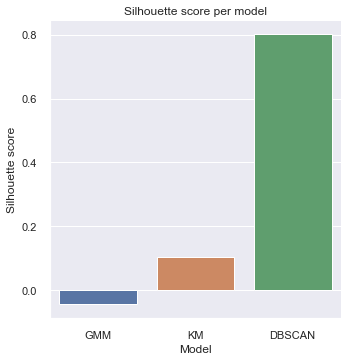

In [197]:
sns.catplot(data=scores_df, kind="bar",x ="Model", y="Silhouette score").set(title="Silhouette score per model")

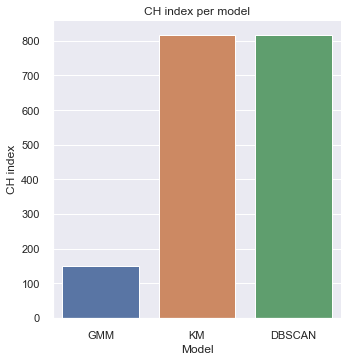

In [198]:
sns.catplot(data=scores_df, kind="bar",x ="Model", y="CH index").set(title="CH index per model")

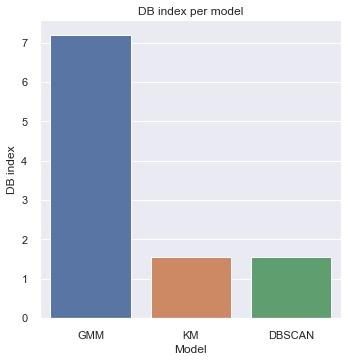

In [199]:
sns.catplot(data=scores_df, kind="bar",x ="Model", y="DB index").set(title="DB index per model")

## Conclusion

From the comparission above we understand the following :
- The Silhouette score is higher for the DBSCAN model meaning that the clusters it generated are dense enough and well separated. And it's negative point five for GMM meaning that the clusters made by it overlap and instances are classified in the wrong clusters.
- The CH index which evaluates the validity of clusters by using the average between- and within- cluster sum of squares. A better score is a lower one, so GMM scores best by the standards of this metrix. KM and DBSCAN scored poorly on this one.
- The Davies Bouldin index which is the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. A lower value of DB index indicates better results (less similarity). So in our case DBSCAN and Km scored almost the same and their scores are much lower (i.e better) than that of GMM.

From the above, we might conclude that DBSCAN is the best model to use on this dataset. Although, this model's clustering only resulted in 2 clusters which is not enough groups to cluster customers in. Therefore , I would go with the next best model, which is KMeans.

## References

https://tomron.net/2016/11/30/davies-bouldin-index/
https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
https://odsc.medium.com/assessment-metrics-for-clustering-algorithms-4a902e00d92d
https://neptune.ai/blog/clustering-algorithms
https://github.com/LarsTinnefeld/olist_ecom_analysis